# Content Based Filtering

In [1]:
import pandas as pd
import numpy as np
import sklearn
import math
import scipy
import matplotlib.pyplot as plt

from ast import literal_eval
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity, linear_kernel
from sklearn.preprocessing import MinMaxScaler

## Introduction

Recommender systems are systems that make recommendations to a user based on different factors. A recommender system is used to predict ratings a user might give to a specific item. A higher rating means the user is likely to enjoy this item therefore they will be recommended this item.

Many different things can be recommended to users. For example, if you go to Amazon you can see different products that are being recommended. If you go to Netflix you see different shows and movies. For Spotify different music and podcasts are recommended. The list goes on.

The benefits of recommender systems are that it improves the user experience and a lot of big companies rely on recommender systems to bring them profit.

How these recommender systems work is that they recommend items based on other items you have looked at in the past or interacted with. Additionally, some recommender systems combine information from other users as well to make recommendations.

There are different types of recommender systems:
* Simple Recommenders (Based on Popularity or Rating)
* Content-Based Filtering
* Collaborative Filtering
* Hybrid Approaches
* etc

In this notebook, we will be looking into Content-Based Filtering for recommendations

## TMDB Movie Data

In [2]:
credits = pd.read_csv('datasets/tmdb_5000_movie_dataset/tmdb_5000_credits.csv')
movies = pd.read_csv('datasets/tmdb_5000_movie_dataset/tmdb_5000_movies.csv')

In [3]:
credits.sample(1)

,movie_id,title,cast,crew
4725,34101,Hollywood Shuffle,"[{""cast_id"": 1, ""character"": ""Bobby Taylor"", ""...","[{""credit_id"": ""553fd444c3a3683c69000077"", ""de..."


In [4]:
movies.sample(1)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
97,15000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",NaN,315011,"[{""id"": 1299, ""name"": ""monster""}, {""id"": 7671,...",ja,シン・ゴジラ,From the mind behind Evangelion comes a hit la...,9.476999,"[{""name"": ""Cine Bazar"", ""id"": 5896}, {""name"": ...","[{""iso_3166_1"": ""JP"", ""name"": ""Japan""}]",2016-07-29,77000000,120.0,"[{""iso_639_1"": ""it"", ""name"": ""Italiano""}, {""is...",Released,A god incarnate. A city doomed.,Shin Godzilla,6.5,143


In [5]:
movies.columns

Index(['budget', 'genres', 'homepage', 'id', 'keywords', 'original_language',
       'original_title', 'overview', 'popularity', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'vote_average',
       'vote_count'],
      dtype='object')

## Data Exploration

In [6]:
# Rename column movie_id to id and then merging the two dataframe together on id
credits = credits.rename({'movie_id': 'id'}, axis = 1)
df = movies.merge(credits, on = 'id')

In [7]:
df = df.drop_duplicates()

In [8]:
df.shape

(4803, 23)

In [9]:
df.isnull().sum()

budget                     0
genres                     0
homepage                3091
id                         0
keywords                   0
original_language          0
original_title             0
overview                   3
popularity                 0
production_companies       0
production_countries       0
release_date               1
revenue                    0
runtime                    2
spoken_languages           0
status                     0
tagline                  844
title_x                    0
vote_average               0
vote_count                 0
title_y                    0
cast                       0
crew                       0
dtype: int64

There are a lot of null values for the columns *homepage* and *tagline*. Fortunately those columns are not very important in terms of the metadata for the movies because *homepage* is just link to the movie and *tagline* is a catchphrase for a movie. Instead of *tagline* it will be much more useful to use the overview of the movies to see if movies are similar or not

In [10]:
df.dtypes

budget                    int64
genres                   object
homepage                 object
id                        int64
keywords                 object
original_language        object
original_title           object
overview                 object
popularity              float64
production_companies     object
production_countries     object
release_date             object
revenue                   int64
runtime                 float64
spoken_languages         object
status                   object
tagline                  object
title_x                  object
vote_average            float64
vote_count                int64
title_y                  object
cast                     object
crew                     object
dtype: object

In [11]:
# Get Earlies and Latest Release Dates
df['release_date'] = pd.to_datetime(df['release_date'])
print("Earliest Release Date in dataset: " + str(min(df.release_date)))
print("Latest Release Date in dataset: " + str(max(df.release_date)))

Earliest Release Date in dataset: 1916-09-04 00:00:00
Latest Release Date in dataset: 2017-02-03 00:00:00


Text(0, 0.5, 'frequency')

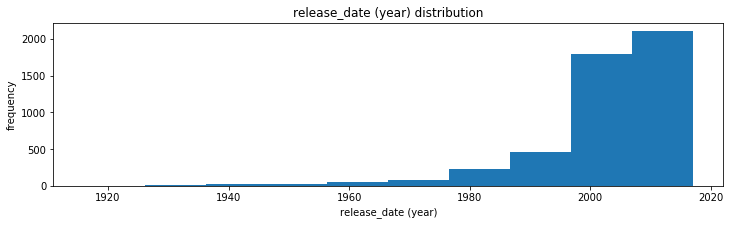

In [12]:
# Distribution of release years 
fig = plt.figure(figsize = (12,3))
plt.hist(df.release_date.dt.year)
plt.title('release_date (year) distribution')
plt.xlabel('release_date (year)')
plt.ylabel('frequency')

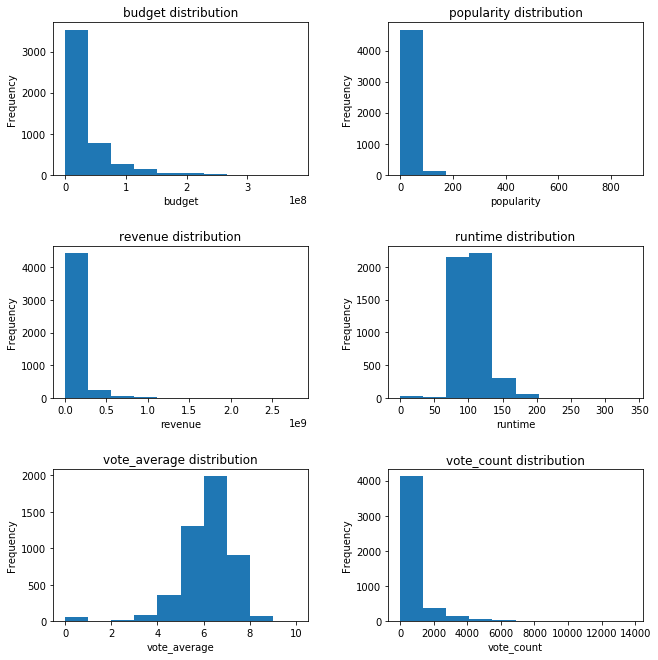

In [13]:
continuous_features = ['budget', 'popularity', 'revenue', 'runtime',
                      'vote_average', 'vote_count']

fig, axes = plt.subplots(nrows = 3, ncols = 2, figsize = [10 ,10])
fig.tight_layout(pad = 5.0)
axes = axes.flatten()
position = 0
for feature in continuous_features:
    axes[position].hist(df[feature])
    axes[position].set_title(feature + " distribution")
    axes[position].set_xlabel(feature)
    axes[position].set_ylabel("Frequency")
    position = position + 1

## Simple Recommender

The simplest recommender system we can build is one that doesn't even use the metadata of the movie; recommends movies based off top-rated or popularity. This is a simple approach to recommending as movies that are popular or more highly rated will have a higher probability of being liked by the average audience.

### Recommendations Using Popularity

#### Popularity

In [14]:
df.sort_values('popularity', ascending = False)[['original_title', 'release_date','popularity']].head(10)

,original_title,release_date,popularity
546,Minions,2015-06-17,875.581305
95,Interstellar,2014-11-05,724.247784
788,Deadpool,2016-02-09,514.569956
94,Guardians of the Galaxy,2014-07-30,481.098624
127,Mad Max: Fury Road,2015-05-13,434.278564
28,Jurassic World,2015-06-09,418.708552
199,Pirates of the Caribbean: The Curse of the Bla...,2003-07-09,271.972889
82,Dawn of the Planet of the Apes,2014-06-26,243.791743
200,The Hunger Games: Mockingjay - Part 1,2014-11-18,206.227151
88,Big Hero 6,2014-10-24,203.734590


### Recommendations Using Rating

#### Weighted Rating

From our data, we have a vote_average feature. The vote_average feature is just the average rating given for that movie. This feature is a little deceiving. Just because a movie has a higher vote_average than another, it does not necessarily mean it is better. We need to take into consideration the number of votes a movie has received. Luckily, we have a vote_count feature in our data that tells us the number of votes a movie has received. A movie with a vote_average of 8 and a vote_count of 10 is not necessarily a better movie than one that has a vote_average of 7.5, but 1000 votes. 

By sorting our data by the vote_average, we get the following results:

In [15]:
df.sort_values('vote_average', ascending = False)[['original_title', 'vote_count', 'vote_average']].head(10)

,original_title,vote_count,vote_average
3519,Stiff Upper Lips,1,10.0
4247,Me You and Five Bucks,2,10.0
4045,"Dancer, Texas Pop. 81",1,10.0
4662,Little Big Top,1,10.0
3992,Sardaarji,2,9.5
2386,One Man's Hero,2,9.3
2970,There Goes My Baby,2,8.5
1881,The Shawshank Redemption,8205,8.5
2796,The Prisoner of Zenda,11,8.4
3337,The Godfather,5893,8.4


These results suggest that "Stiff Upper Lips" and "Me You and Five Bucks" are movies you should watch 🤢 (jk I'm sure they're great movies too). This just shows we can't rely on vote_average to get the top-rated movies especially when the mentioned movies are listed above "The Shawshank Redemption" and "The Godfather" which are some GOATed movies. 
So, how can we get the top movies? What we can do is use IMDB's Weighted Rating system on our movie dataset. The formula for the weighted rating is:

**IMDB** uses a weighted rating for their movies. The formula for the weighted rating is:

$$WR = (\frac{v}{v + m})R + (\frac{m}{v + m})C$$

* R - average rating for the movie (the *vote_average* column)
* v - number of votes for the movie (the *vote_count* column)
* m - minimum votes required to be listed (need to calculate this)
* C - average vote across entire data (need to calculate this)

In [16]:
c = df['vote_average'].mean()
m = df['vote_count'].quantile(0.90)
df_top_rated = df.copy().loc[df['vote_count'] >= m]
print(df_top_rated.shape)

(481, 23)


There are 481 movies that fit the minimum number of votes needed to make the top-rated list.

By computing the weighted rating and sorting by the highest weighted rating we get the following results:

There are 481 movies that fit the minimum number of votes needed to make the top-rated list.

In [17]:
def weighted_rating(movie, m=m, c=c):
    R = movie['vote_average']
    v = movie['vote_count']
    
    weighted_rate = (v/(v+m)*R) + (m/(m+v)*c)
    return weighted_rate
    
df_top_rated['weighted_rating'] = df_top_rated.apply(weighted_rating, axis = 1)

In [18]:
df_top_rated.sort_values('weighted_rating', ascending = False)[['original_title', 'weighted_rating']].head(10)

,original_title,weighted_rating
1881,The Shawshank Redemption,8.059258
662,Fight Club,7.939256
65,The Dark Knight,7.920020
3232,Pulp Fiction,7.904645
96,Inception,7.863239
3337,The Godfather,7.851236
95,Interstellar,7.809479
809,Forrest Gump,7.803188
329,The Lord of the Rings: The Return of the King,7.727243
1990,The Empire Strikes Back,7.697884


These results make much more sense as these are some really great movies. 

The advantage of this type of approach is that it is very simple. It does not require any sort of user data to make recommendations. It simply recommends the top-rated movies which most of the time the average viewer will enjoy watching.

The disadvantage of this type of approach is that it is not tailored to an individual. It recommends the same movie to everyone. What if you aren't like the average viewer and you don't like what is popular? If we really want to enhance user experience, we need the recommender system to make more personalized recommendations.

## Content-Based Filtering

For Content-Based Filtering, we are not looking at the behavior of other users, we are using the attributes of the movies to make recommendations.


## Recommendations Using the Overview

We can use the overview column to help make movie recommendations. If you enjoy a movie, it is very likely you will enjoy another with a similar plot or overview.
How do we calculate whether two plots are similar or not? We need to convert the overview from a sequence of words into numbers which we can use to calculate some sort of similarity score.

In [ ]:
# # stemming
# df['overview'] = df['overview'].astype(str)                                                        
# df['overview'] = df['overview'].apply(lambda x: [item for item in x.split()])

# df['overview'] = df['overview'].apply(lambda x: " ".join([stemmer.stem(i) for i in x]))
# df['overview']

### Term Frequency - Inverse Document Frequency (TF-IDF) On Movie Overview

We will be using TF-IDF to convert the overviews into a number of vectors where the numbers of the vectors represent the content of the text. TF-IDF determines how important a word is to a text document (overview in our case) in a collection of documents (overviews) in a dataset. Essentially, it is a weighting factor for words. TF-IDF gives a score for each word, the higher the score, the more relevant it is. This is done by multiplying two terms together: TF x IDF

$$w_{i,j} = tf_{i,j} * idf_i$$

TF is the Term Frequency. It is the number of times a word appears in a document. For example: if the word superhero appears 9 times in a 100-word overview, the term frequency would be 0.09.

IDF is the Inverse Document Frequency. It is the weight of the word. If the word appears often throughout all of the overviews in the dataset, then it does not have much weight. Below is the equation for this term:

$$idf_i = log(\frac{n}{df_i})$$

Where n is the number of overviews, and df is the document frequency; the number of overviews containing a specific word.

In [19]:
# remove stopwords. Stopwords are common words that add no meaning to the text
tfidf_model = TfidfVectorizer(stop_words = 'english')
tfidf_overview = tfidf_model.fit_transform(df['overview'].values.astype('str'))

In [20]:
tfidf_overview.shape

(4803, 20979)

The shape of the tfidf matrix tells us that 20979 unique words (after removing stopwords) were used to described the 4803 movies. 

Once we have computed the TF-IDF for all the overviews in the dataset, we end up with an N x M matrix where N is the number of movies in our dataset and M is the number of unique words used to describe all the movies. Therefore each row represents a movie and the columns are individual words. Each movie is represented by a vector where the values inside the vector are the weights of the word if it appears in the movie's overview. Below is what our movie overviews look like after TF-IDF:

In [21]:
word_set = tfidf_model.get_feature_names()
tfidf_array = tfidf_overview.toarray()
print(tfidf_array)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [22]:
df_tfidf_overview = pd.DataFrame(tfidf_array, columns = word_set)
df_tfidf_overview.head()

,00,000,007,07am,10,100,1000,101,108,10th,...,zuckerberg,zula,zuzu,zyklon,æon,éloigne,émigré,été,única,über
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


It is a very sparse matrix, but you can see each movie is represented by a vector and a weight assigned for each word. We will be using this matrix of vectors to calculate the similarity between movies.

### Cosine Similarity

Cosine Similarity is a measurement that computes how similar two vectors are to each other. We will be using the results of TF-IDF and compute the Cosine Similarity as the movies are now represented by vectors. 

The equation for Cosine Similarity is:

$$\cos(\theta) = \frac{A\cdot B}{||A||||B||}$$

The numerator is the dot product between vector A and vector B. The denominator is the magnitude of vector A multiplied by the magnitude of vector B.

The result after computing the cosine similarity is an N x N matrix where N is the number of movies.

In [23]:
cosine_score = linear_kernel(tfidf_overview, tfidf_overview)

In [24]:
cosine_score

array([[1.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 1.        , 0.        , ..., 0.02160533, 0.        ,
        0.        ],
       [0.        , 0.        , 1.        , ..., 0.01488159, 0.        ,
        0.        ],
       ...,
       [0.        , 0.02160533, 0.01488159, ..., 1.        , 0.01609091,
        0.00701914],
       [0.        , 0.        , 0.        , ..., 0.01609091, 1.        ,
        0.01171696],
       [0.        , 0.        , 0.        , ..., 0.00701914, 0.01171696,
        1.        ]])

We now have a matrix of values between 0 and 1. We will visualize this in a dataframe to better understand what these values mean.

In [25]:
cosine_df = pd.DataFrame(cosine_score, columns = df['original_title'].values.tolist())
cosine_df.index = df['original_title'].values.tolist()

In [26]:
cosine_df.head()

,Avatar,Pirates of the Caribbean: At World's End,Spectre,The Dark Knight Rises,John Carter,Spider-Man 3,Tangled,Avengers: Age of Ultron,Harry Potter and the Half-Blood Prince,Batman v Superman: Dawn of Justice,...,On The Downlow,Sanctuary: Quite a Conundrum,Bang,Primer,Cavite,El Mariachi,Newlyweds,"Signed, Sealed, Delivered",Shanghai Calling,My Date with Drew
Avatar,1.000000,0.000000,0.0,0.024995,0.000000,0.030353,0.000000,0.037581,0.000000,0.000000,...,0.000000,0.0,0.029175,0.042176,0.000000,0.0,0.0,0.000000,0.000000,0.000000
Pirates of the Caribbean: At World's End,0.000000,1.000000,0.0,0.000000,0.033369,0.000000,0.000000,0.022676,0.000000,0.000000,...,0.000000,0.0,0.006895,0.000000,0.000000,0.0,0.0,0.021605,0.000000,0.000000
Spectre,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.030949,0.024830,0.000000,...,0.027695,0.0,0.000000,0.000000,0.017768,0.0,0.0,0.014882,0.000000,0.000000
The Dark Knight Rises,0.024995,0.000000,0.0,1.000000,0.010433,0.005145,0.012601,0.026954,0.020652,0.133740,...,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.033864,0.042752,0.022692
John Carter,0.000000,0.033369,0.0,0.010433,1.000000,0.000000,0.009339,0.037407,0.000000,0.017148,...,0.012730,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.006126,0.000000,0.000000


We have a new dataframe where every movie is on the row and on the columns. We look at the intersection of any two given movies and find the similarity score to each other. You can also see that movies have a perfect similarity score with themselves.

In [27]:
cosine_df.iloc[0]

Avatar                                      1.000000
Pirates of the Caribbean: At World's End    0.000000
Spectre                                     0.000000
The Dark Knight Rises                       0.024995
John Carter                                 0.000000
                                              ...   
El Mariachi                                 0.000000
Newlyweds                                   0.000000
Signed, Sealed, Delivered                   0.000000
Shanghai Calling                            0.000000
My Date with Drew                           0.000000
Name: Avatar, Length: 4803, dtype: float64

### Make Recommendations

Using the results from cosine similarity, we can write a function that gets movies with the highest similarity score for an inputted movie.

In [28]:
movie_index = pd.Series(df.index, index = df['original_title'])
movie_titles = df['original_title']

def recommend_movie(movie):
    # get the index of the movie
    index = movie_index[movie]
    # convert into a list of movie index and similarity values
    similarity = list(enumerate(cosine_score[index]))
    # sort list by the similarity value
    similarity = sorted(similarity, key = lambda x: x[1], reverse = True)
    # Get the top 10 most similar movies. Exclude the first value because it is itself.
    similarity = similarity[1:11]
    recommended_index = [i[0] for i in similarity] 
    recommended_title = [movie_titles[i] for i in recommended_index]
    recommended_score = [i[1] for i in similarity]
    return pd.DataFrame({'Recommended_Movie': recommended_title,
                         'Score': recommended_score})
    

In [29]:
recommend_movie('The Empire Strikes Back')

,Recommended_Movie,Score
0,Star Wars,0.422981
1,Return of the Jedi,0.332226
2,Star Wars: Episode III - Revenge of the Sith,0.218126
3,Decoys,0.146519
4,Star Wars: Episode I - The Phantom Menace,0.113766
5,Sardaarji,0.085509
6,Star Wars: Episode II - Attack of the Clones,0.082092
7,The Loss of Sexual Innocence,0.079202
8,United Passions,0.079029
9,Star Wars: Clone Wars (Volume 1),0.077902


Using the overview feature, we get movies that have a similar overview to the movie we wanted recommendations for. For example, we wanted recommendations for “The Empire Strikes Back” and we got several other Star Wars movies returned. 

The issue with strictly using the overview is that that take into consideration other factors that contribute to someone liking a movie. What if someone liked a certain genre of movies or movies directed by a certain director? In the next section we will take those features into account when making recommendations.

### Recommendations Using Movies Features

Our approach to making recommendations using features will be very similar to what we did for making recommendations using the overview. We will combine the features *genres, keywords, cast*, and *crew* into one sequence of text (almost acting like a short description) for each movie, convert each text into a matrix of vectors, and then compute a similarity score.

In [30]:
df.iloc[0]

budget                                                          237000000
genres                  [{"id": 28, "name": "Action"}, {"id": 12, "nam...
homepage                                      http://www.avatarmovie.com/
id                                                                  19995
keywords                [{"id": 1463, "name": "culture clash"}, {"id":...
original_language                                                      en
original_title                                                     Avatar
overview                In the 22nd century, a paraplegic Marine is di...
popularity                                                     150.437577
production_companies    [{"name": "Ingenious Film Partners", "id": 289...
production_countries    [{"iso_3166_1": "US", "name": "United States o...
release_date                                          2009-12-10 00:00:00
revenue                                                        2787965087
runtime                               

The following columns in the dataset contain lists of dictionaries as their values: *genres, keywords, production_companies, production_countries, spoken_languages, cast, crew*. 

We will extract the important medadata from these dictionaries and have the values in a list. 

For example, for the genre column we want the final output to look like this: [action, comedy].

We will define a couple of helper functions that will extract the necessary metadata for our dataset columns

First lets take a look at the different dictionaries and which key value we need to extract.

* **genres** - name
* **keywords** - name
* **production_companies** - name
* **production_countries** - name
* **spoken_languages** - name
* **cast** - name
* **crew** - find "job": "Director" and get name value

We can write a function that takes all the values from the *name* key. However, as we can see from the above output, there are a lot of values for some of the features such as *cast* and *crew*. We do not want to include all those features as we will have a super high-dimension matrix that will be very sparse aswell. 

For cast we can just take the top N values because usually the people with the most screentime are listed first on the cast lists.

For crew we will just fetch the Director of the movie.


In [31]:
print(df['genres'].iloc[0])
print("")
print(df['genres'].iloc[0][0]) # First element of first movie genres dictionary

[{"id": 28, "name": "Action"}, {"id": 12, "name": "Adventure"}, {"id": 14, "name": "Fantasy"}, {"id": 878, "name": "Science Fiction"}]

[


In [32]:
# Convert strings into actual list objects

dict_features = ['genres', 'keywords', 'cast','crew']

for feature in dict_features:
    df[feature] = df[feature].apply(literal_eval)

print(df['genres'].iloc[0][0])

{'id': 28, 'name': 'Action'}


In [33]:
def get_director(crew_column):
    for i in crew_column:
        if i['job'] == 'Director':
            meta_data = i['name']
            return [meta_data]
    return []

def extract_metadata(dict_column):
    
    if isinstance(dict_column, list):        
        metadata = [i['name'] for i in dict_column]
        return metadata
    return []

In [34]:
df[dict_features[-1]] = df[dict_features[-1]].apply(get_director)

for feature in dict_features[:3]:
    df[feature] = df[feature].apply(extract_metadata)

df['cast'] = df['cast'].apply(lambda x: x[:3] if len(x) >= 3 else x)


### Preprocessing

#### Cast and Crew

For the cast and crew column, we are going to remove the spaces between the first and last names to make it into one big string. This is to avoid mistaking people with the same first name as the same actor.

In [35]:
# For the cast and crew columns
df['cast'] = df['cast'].apply(lambda x: [str.lower(i.replace(" ","")) for i in x])
df['crew'] = df['crew'].apply(lambda x: [str.lower(i.replace(" ","")) for i in x])
df['genres'] = df['genres'].apply(lambda x: [str.lower(i.replace(" ", "")) for i in x])

df[['genres', 'keywords', 'cast', 'crew']].head(3)

,genres,keywords,cast,crew
0,"[action, adventure, fantasy, sciencefiction]","[culture clash, future, space war, space colon...","[samworthington, zoesaldana, sigourneyweaver]",[jamescameron]
1,"[adventure, fantasy, action]","[ocean, drug abuse, exotic island, east india ...","[johnnydepp, orlandobloom, keiraknightley]",[goreverbinski]
2,"[action, adventure, crime]","[spy, based on novel, secret agent, sequel, mi...","[danielcraig, christophwaltz, léaseydoux]",[sammendes]


#### Keywords

We want to filter some of the keywords. Some keywords are only used once to describe one movie and this will not very helpful if no other movies use those keywords. We will filter the keywords using only words that appear more than once

In [36]:
df.keywords.explode().dropna().value_counts()

woman director          324
independent film        318
duringcreditsstinger    307
based on novel          197
murder                  189
                       ... 
kronos                    1
cultural revolution       1
reeducation camp          1
manchuria                 1
postal worker             1
Name: keywords, Length: 9813, dtype: int64

Key words/phrases that only appear once will not be helpful for making recommendations so we can filter those out

In [37]:
words = df.keywords.explode().dropna()
words.name = 'keyword'
words = words.value_counts()
words = words[words > 1]
words

woman director          324
independent film        318
duringcreditsstinger    307
based on novel          197
murder                  189
                       ... 
galactic war              2
mole                      2
impregnation              2
plot                      2
asgard                    2
Name: keyword, Length: 4502, dtype: int64

In [38]:
# helper functions for preprocessing this meta data.

def top_keywords_words(keywords):
    list_of_words = []
    for i in keywords:
        if i in words:
            list_of_words.append(i)
    return list_of_words

df['keywords'] = df['keywords'].apply(top_keywords_words)

#### Stemming

Stemming is a text processing method that reduces words to their root words. For example if we had the word *baked* in our text, it would be reduced to *bake*. This is used to reduce the feature space of our dataset. Additionally, it'll words such as *baked* and *bake* as one word as oppose to two different words even though they mean the same thing context-wise.

In [39]:
stemmer = SnowballStemmer('english')

df['keywords'] = df['keywords'].apply(lambda x: [stemmer.stem(i) for i in x])
df['keywords'] = df['keywords'].apply(lambda x: [str.lower(i.replace(" ", "")) for i in x])

#### Combining Features

We will combine the features *genres, keywords, cast*, and *crew* into one sequence of text (almost acting like a short description) for each movie, convert each text into a matrix of vectors, and then compute a similarity score.

In [40]:
df['combine'] = df['genres'] + df['keywords'] + df['cast'] + df['crew']
df['combine'] = df['combine'].apply(lambda x: ' '.join(x))
df['combine'].iloc[0]

'action adventure fantasy sciencefiction cultureclash futur spacewar spacecoloni societi spacetravel futurist romanc space alien tribe alienplanet cgi marin soldier battl loveaffair antiwar powerrel mindandsoul 3d samworthington zoesaldana sigourneyweaver jamescameron'

### Count Vectorizer

CountVectorizer is a method used to convert text data into numerical values that we can use for different machine-learning applications. It transforms our movie text into a matrix where the rows represent the text from one movie, and the columns represent each unique word from all the different movie texts. The value for each cell in the matrix is just a count of how many times a word appears in a movie text.

In [41]:
count_vect = CountVectorizer(analyzer = 'word', stop_words = 'english')
count_matrix = count_vect.fit_transform(df['combine'])
count_matrix.shape

(4803, 12457)

From our movie feature text, we get the following results after CountVectorizer:

In [42]:
word_set = count_vect.get_feature_names()
count_array = count_matrix.toarray()
print(count_array)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [43]:
df_count = pd.DataFrame(count_array, columns = word_set)
df_count.head()

,11,15thcenturi,16thcenturi,17thcenturi,18thcenturi,1910s,1930s,1940s,1950s,1960s,...,àlexpastor,álexdelaiglesia,émilegaudreault,émiliedequenne,érictessier,étiennefaure,óscarjaenada,đỗthịhảiyến,špelacolja,юлияснигирь
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Cosine Similarity

The result after computing the cosine similarity yields the same results as the previous recommender using overview: an N x N matrix where N is the number of movies.

In [44]:
cosine_score = cosine_similarity(count_matrix, count_matrix)
cosine_score

array([[1.        , 0.11371471, 0.09925833, ..., 0.        , 0.        ,
        0.        ],
       [0.11371471, 1.        , 0.10910895, ..., 0.        , 0.        ,
        0.        ],
       [0.09925833, 0.10910895, 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ]])

In [45]:
cosine_df = pd.DataFrame(cosine_score, columns = df.original_title.values.tolist())
cosine_df.index = df.original_title.values.tolist()
cosine_df.head()

,Avatar,Pirates of the Caribbean: At World's End,Spectre,The Dark Knight Rises,John Carter,Spider-Man 3,Tangled,Avengers: Age of Ultron,Harry Potter and the Half-Blood Prince,Batman v Superman: Dawn of Justice,...,On The Downlow,Sanctuary: Quite a Conundrum,Bang,Primer,Cavite,El Mariachi,Newlyweds,"Signed, Sealed, Delivered",Shanghai Calling,My Date with Drew
Avatar,1.000000,0.113715,0.099258,0.035093,0.243132,0.121566,0.000000,0.185695,0.099258,0.148888,...,0.000000,0.000000,0.000000,0.043769,0.000000,0.058722,0.0,0.000000,0.0,0.0
Pirates of the Caribbean: At World's End,0.113715,1.000000,0.109109,0.038576,0.089087,0.222718,0.000000,0.102062,0.109109,0.163663,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.064550,0.0,0.000000,0.0,0.0
Spectre,0.099258,0.109109,1.000000,0.101015,0.174964,0.174964,0.000000,0.200446,0.071429,0.142857,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.169031,0.0,0.000000,0.0,0.0
The Dark Knight Rises,0.035093,0.038576,0.101015,1.000000,0.041239,0.082479,0.000000,0.094491,0.000000,0.202031,...,0.052414,0.066815,0.059761,0.089087,0.109109,0.179284,0.0,0.052414,0.0,0.0
John Carter,0.243132,0.089087,0.174964,0.041239,1.000000,0.095238,0.051434,0.218218,0.058321,0.116642,...,0.000000,0.000000,0.000000,0.051434,0.000000,0.069007,0.0,0.000000,0.0,0.0


### Make Recommendations

Using the results from cosine similarity and our recommend_movie function, we can see what recommendations we get for "The Empire Strikes Back" this time.

In [46]:
def recommend_movie(movie):
    # get the index of the movie
    index = movie_index[movie]
    # convert into a list of movie index and similarity values
    similarity = list(enumerate(cosine_score[index]))
    # sort list by the similarity value
    similarity = sorted(similarity, key = lambda x: x[1], reverse = True)
    # Get the top 10 most similar movies. Exclude the first value because it is itself.
    similarity = similarity[1:11]
    recommended_index = [i[0] for i in similarity] 
    recommended_title = [movie_titles[i] for i in recommended_index]
    recommended_score = [i[1] for i in similarity]
    return pd.DataFrame({'Recommended_Movie': recommended_title,
                         'Score': recommended_score})

In [47]:
recommend_movie('The Empire Strikes Back')

,Recommended_Movie,Score
0,Star Wars,0.619048
1,Return of the Jedi,0.600099
2,Starship Troopers,0.292770
3,Star Trek II: The Wrath of Khan,0.281718
4,Star Trek Beyond,0.263181
5,Star Wars: Clone Wars (Volume 1),0.263181
6,Star Trek: Insurrection,0.251976
7,The Helix... Loaded,0.251976
8,Star Wars: Episode II - Attack of the Clones,0.250313
9,Star Trek: Nemesis,0.238095


We can see that the recommendations made this time aren't all Star Wars movies which is good! Star Wars movies are great, but isn't it even greater to discover new movies that are similar? Now you can watch Star Wars, Star Trek, and Starship Troopers!